## First model

### Set up

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
from fastai.imports import *

In [10]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [63]:
PATH = '../../fastai/courses/dl1/data/cars/'
sz = 224

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

In [12]:
!ls {PATH}

bmw  mersedes  test  train  valid


In [13]:
!ls {PATH}valid

bmw  mersedes


In [43]:
!tree {PATH} -d

../../fastai/courses/dl1/data/cars/
├── bmw
├── mersedes
├── models
├── test
│   ├── bmw
│   └── mersedes
├── tmp
│   ├── x_act_resnet34_0_224.bc
│   │   ├── data
│   │   └── meta
│   ├── x_act_test_resnet34_0_224.bc
│   │   ├── data
│   │   └── meta
│   └── x_act_val_resnet34_0_224.bc
│       ├── data
│       └── meta
├── train
│   ├── bmw
│   └── mersedes
└── valid
    ├── bmw
    └── mersedes

22 directories


In [64]:
# print number of files in each folder
print('training data: bmw')
!ls -l {PATH}train/bmw | grep ^[^d] | wc -l

print('training data: mersedes')
!ls -l {PATH}train/mersedes | grep ^[^d] | wc -l

print('validation data: bmw')
!ls -l {PATH}valid/bmw | grep ^[^d] | wc -l

print('validation data: mersedes')
!ls -l {PATH}valid/mersedes | grep ^[^d] | wc -l

print('test data')
!ls -l {PATH}test | grep ^[^d] | wc -l

training data: bmw
156
training data: mersedes
159
validation data: bmw
40
validation data: mersedes
39
test data
1


In [25]:
files = !ls {PATH}train/bmw | head
files

In [17]:
files = os.listdir(f'{PATH}valid/mersedes')[:5]
files

['42.jpg', '72.jpg', '126.jpg', '177.jpg', '65.jpg']

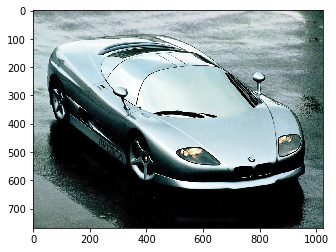

In [26]:
img = plt.imread(f'{PATH}train/bmw/{files[41]}')
plt.imshow(img);

In [27]:
img.shape

(768, 1024, 3)

In [17]:
#!rm -rf {PATH/tmp}

### Basic model

In [87]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, bs=16, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy         
    0      0.659906   0.667169   0.714423  
    1      0.527002   0.519892   0.823077         



[0.5198917, 0.8230769276618958]

### Analyze results by looking at pictures

In [88]:
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

In [89]:
data.val_y[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [90]:
data.classes

['bmw', 'mersedes']

In [91]:
log_preds = learn.predict()
log_preds.shape

(77, 2)

In [92]:
log_preds[:10]

array([[-0.0047 , -5.36285],
       [-0.18896, -1.75923],
       [-0.02199, -3.82799],
       [-0.14787, -1.98445],
       [-0.45085, -1.01359],
       [-0.89024, -0.52858],
       [-0.13733, -2.05326],
       [-0.73788, -0.65033],
       [-0.00973, -4.6371 ],
       [-0.08931, -2.45992]], dtype=float32)

In [93]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

In [94]:
preds.mean(), probs.mean()

(0.42857142857142855, 0.42465135)

In [95]:
def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct):
    return rand_by_mask((preds == data.val_y)==is_correct)

In [96]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [97]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

Correctly classified


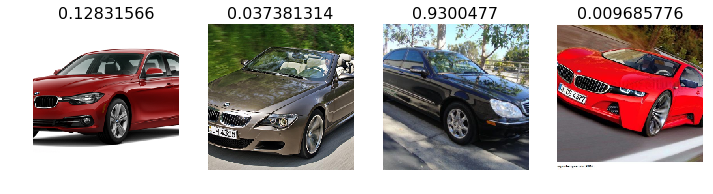

In [99]:
plot_val_with_title(rand_by_correct(True), 'Correctly classified')

Incorrectly classified


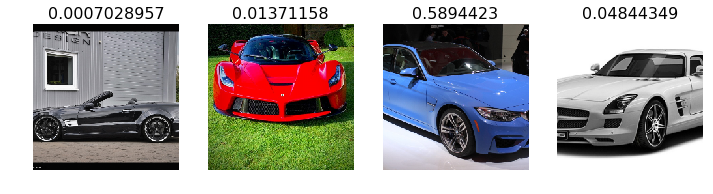

In [100]:
plot_val_with_title(rand_by_correct(False), 'Incorrectly classified')

In [101]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct bmw


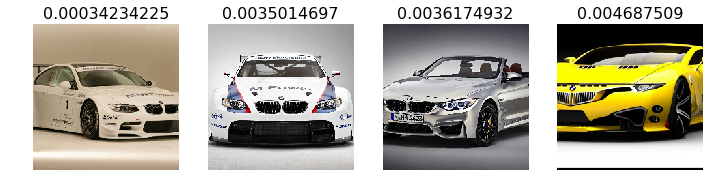

In [102]:
plot_val_with_title(most_by_correct(0, True), 'Most correct bmw')

Most correct mersedes


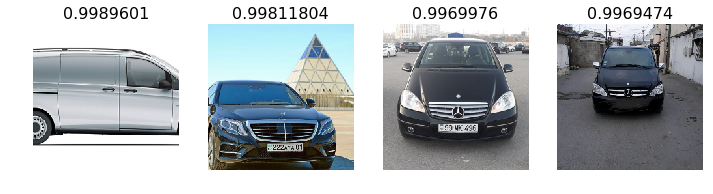

In [103]:
plot_val_with_title(most_by_correct(1, True), 'Most correct mersedes')

Most incorrect bmw


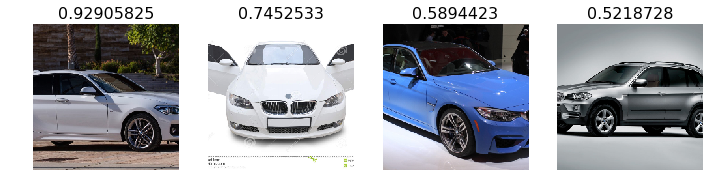

In [104]:
plot_val_with_title(most_by_correct(0, False), 'Most incorrect bmw')

Most incorrect mersedes


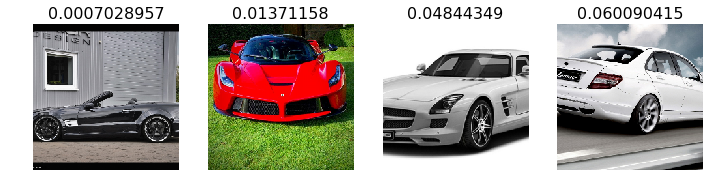

In [105]:
plot_val_with_title(most_by_correct(1, False), 'Most incorrect mersedes')

Most uncertain predictions


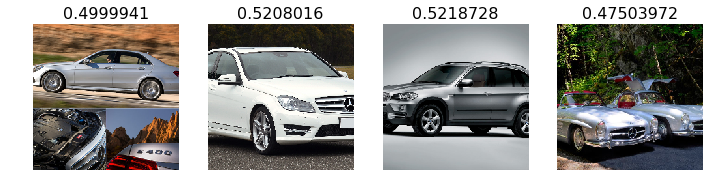

In [106]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, 'Most uncertain predictions')

### Choosing a learning rate

In [68]:
data = ImageClassifierData.from_paths(PATH, bs=8, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 55%|█████▌    | 22/40 [00:00<00:00, 169.69it/s, loss=6.35] 


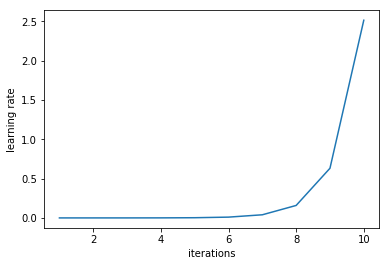

In [61]:
learn.sched.plot_lr()

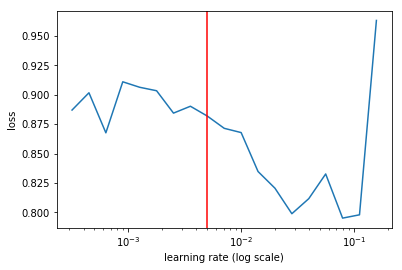

In [69]:
import matplotlib.pyplot as plt
learn.sched.plot()
plt.axvline(x=5e-3, color="red");

## Improving the model

### Data augmentation

In [107]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [108]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [109]:
ims = np.stack([get_augs() for i in range(6)])

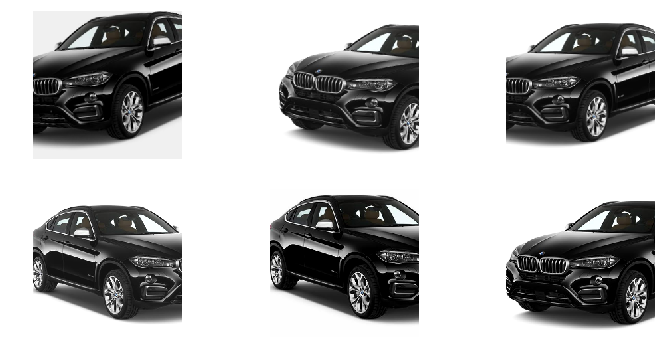

In [110]:
plots(ims, rows=2)

In [128]:
data = ImageClassifierData.from_paths(PATH, bs=16, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [113]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/20 [00:00<?, ?it/s, loss=5.26] 


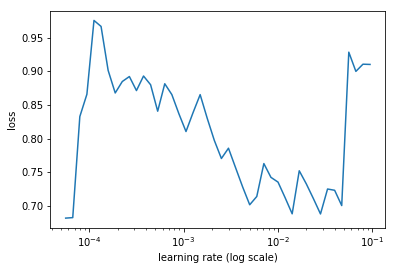

In [91]:
learn.sched.plot()

In [129]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy         
    0      0.760208   0.566963   0.729808  



[0.5669633, 0.7298076927661896]

In [130]:
learn.precompute=False

### learning rate annealing

In [131]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.499597   0.48463    0.732692  
    1      0.461746   0.628284   0.689423                  
    2      0.429671   0.664722   0.742308                  



[0.66472214, 0.7423076927661896]

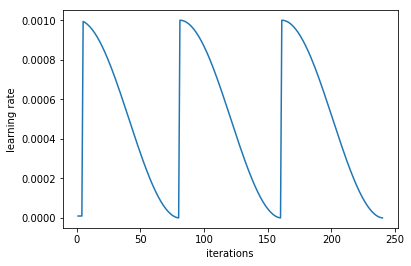

In [70]:
learn.sched.plot_lr()

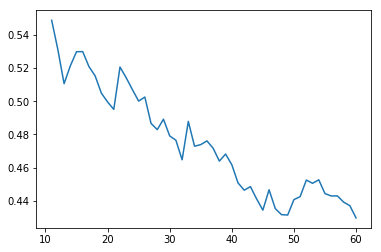

In [132]:
learn.sched.plot_loss()

In [72]:
#learn.save('224_lastlayer_1')

In [73]:
#learn.load('224_lastlayer_1')

### Fine-tuning and differential learning rate annealing

In [133]:
learn.unfreeze()

In [134]:
lr=np.array([1e-4,1e-3,1e-2])

In [135]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.536285   0.667769   0.767308  
    1      0.495757   0.651193   0.795192                  
    2      0.413476   0.523343   0.817308                  
    3      0.350622   0.544084   0.853846                  
    4      0.274377   0.731355   0.878846                  
    5      0.235379   0.841372   0.850962                  
    6      0.199733   0.791358   0.866346                  



[0.79135823, 0.8663461565971374]

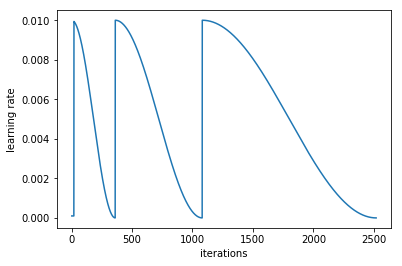

In [91]:
learn.sched.plot_lr()

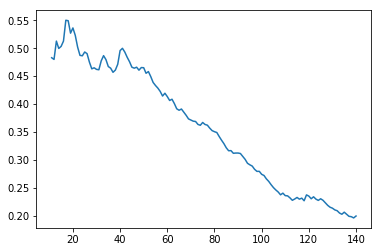

In [136]:
learn.sched.plot_loss()

In [94]:
learn.save('224_all_1')

In [95]:
learn.load('224_all_1')

## Test Time Augmentation

In [137]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)

In [138]:
accuracy_np(probs, y)

0.8701298701298701

## Analyzing results

### Confution matrix

In [139]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [140]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[38  1]
 [ 9 29]]


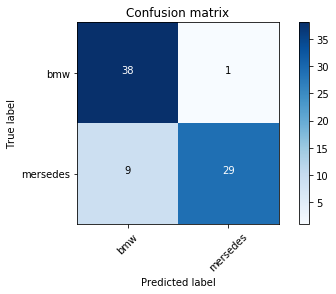

In [141]:
plot_confusion_matrix(cm, data.classes)

#### Looking at pictures again

Most incorrect cats


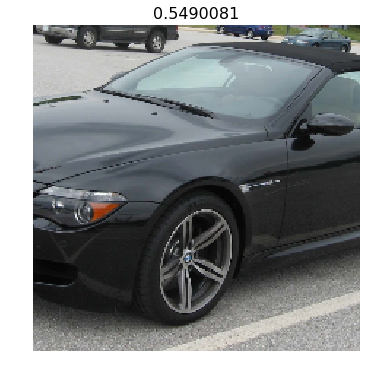

In [142]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


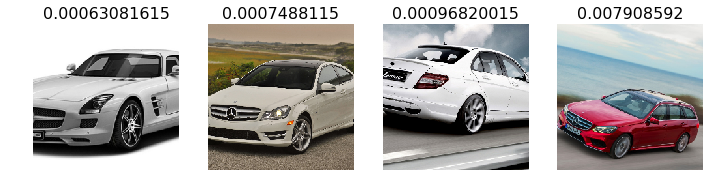

In [143]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


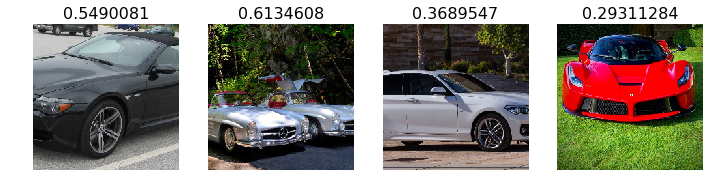

In [144]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, 'Most uncertain predictions')